# **Week 3: Lab Exercises for COMP499/691 Conversational AI**

The goal of this lab is to familiarize yourself with **Convolutional Neural Networks** (CNNs).

In this lab, you will implement a **convolutional autoencoder** with [SpeechBrain](https://speechbrain.github.io/). 

An [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) is a neural network that attempts to predict the inputs itself. 

Without adding anything special, the task would be very trivial. The network can copy and paste the output using a simple identity function. To make the task more meaningful, we add a **bottleneck** in the architecture. The bottleneck compresses the information such that identity mapping is not possible, and we thus force the model to learn a meaningful compressed representation of the input.


The autoencoder is composed of an **encoder** and a **decoder**. The encoder turns the input into a compressed representation (bottleneck). The decoder, instead, attempts to reconstruct the original signal on top of the compressed representation. 

Such an architecture is suitable for feature learning. If the encoder is well designed, we should learn some useful representation in the output. We will use this representation as input features for an audio digit classifier.


As in the previous lab, we will work with the [audio MNIST dataset](https://www.kaggle.com/datasets/alanchn31/free-spoken-digits). 


**Run the code below** to install SpeechBrain:


In [ ]:
%%capture
!pip install speechbrain

If everything works well, you should be able to import speechbrain like this:

In [ ]:
import speechbrain

Let's also import some libraries that will be useful later:

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
torch.manual_seed(2023)

**Run the code below** to download the audio MNIST dataset. The dataset is quite big (downloading it might take a few minutes).

In [ ]:
!git clone https://github.com/soerenab/AudioMNIST /content/AudioMNIST

##**Exercise 1 - Data Preparation**

The goal is to create the data manifest files (in CSV format) that SpeechBrain expects in input. These files tell SpeechBrain where to find the speech data and their corresponding labels for the training, validation, and test sets.

You have to create 3 JSON files (`tran.json`, `valid.json`, `test.json`) structured in this way:


```
{
  "6_10_30.wav": {
    "wav": "AudioMNIST/data/10/6_10_30.wav",
    "length": 0.7466041666666666,
    "digit": "6"
  },
  "4_10_22.wav": {
    "wav": "AudioMNIST/data/10/4_10_22.wav",
    "length": 0.6258125,
    "digit": "4"
  },
  ........
```


In particular, we split the dataset in this way:
- `training` with speakers from 1 to 10.
- `validation` with speakers from 11 to 14.
- `test` with speakers from 15 to 18.

Note that we are using only a portion of the dataset to make training faster. 

**This step is the same as the previous lab. You can copy and paste the code from the previous lab if you have done it.**


**Write the code for the AudioMNIST data preparation**. 

In [ ]:
# Your code here.

# Creating JSON files
create_json('train.json', train_files)
create_json('valid.json', valid_files)
create_json('test.json', test_files)   

5000
2000
2000


###**Exercise 2 - Convolutional Autoencoder**

In this exercise, you will implement a convolutional autoencoder. In particular, we ask you to implement the following model:

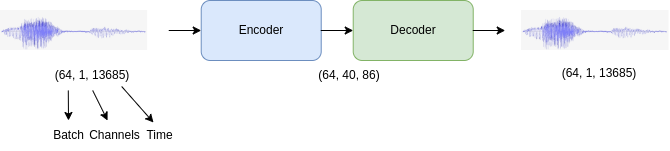

In the figure, we also report an example of the expected dimensionalities. The last dimensionality is the time that will change from batch to batch.

The **encoder** should have the following architecture:

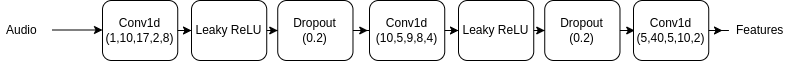

The encoder is composed of three strided convolutions that downsample the time dimension to a factor of 160 (at 16 kHz, this corresponds to having a feature every 10 ms of speech signal). We also use *Leaky ReLU* activations and dropout for regularization. 

Use the models defined in `torch.nn` to implement it.
In the brackets you find the hyperparameters to use (in the order in which they appear in the PyTorch documentation).

The **decoder** has the following architecture:

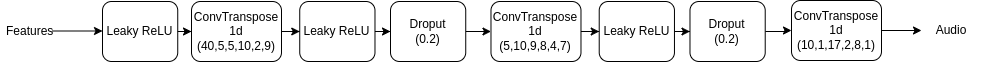

The decoder upsamples the features by a factor of 160 using three transposed convolutions. Dropout and leaky ReLU are used as well. The output of the decoder attempts to predict the original audio signal. 

Use the models defined in torch.nn to implement it.
In the brackets, you find the hyperparameters to use (in the order in which they appear in the PyTorch documentation).

**Complete the code below** to implement the desired autoencoder.

In [ ]:
%%file models.py

import torch
from torch import nn
from torch.nn import Conv1d, ConvTranspose1d, LayerNorm, Sequential, Dropout, LeakyReLU

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Your code here. Aim for 8-9 lines. 
        # Suggestion: Use the torch.nn sequential container.
        
    def forward(self, x):
        # Your code here. Aim for 1-2 lines. 
        return out


class Decoder(nn.Module):
    def __init__(self, inp_channels=40):
        super().__init__()
        # Your code here. Aim for 9-10 lines. 
        # Suggestion: Use the torch.nn sequential container.      
        
    def forward(self, x):
        # Your code here. Aim for 1-2 lines. 
        return out



**Run the code below** to test your model. 

In [ ]:
# Importing the library from the file. 
# This is reloaded every time to allow modifications of library file.
import importlib 
import models
importlib.reload(models) 
from models import Encoder, Decoder

# Initialization
encoder = Encoder()
decoder = Decoder()

# Using the encoder and decoder
input = torch.rand(4, 1, 8000)
print(input.shape)

enc_output = encoder(input)
dec_output = decoder(enc_output)
print(enc_output.shape)
print(dec_output.shape)

If everything works well, you should obtain the following dimensionalities:



```
torch.Size([4, 1, 8000])
torch.Size([4, 40, 50])
torch.Size([4, 1, 8000])
```



Now, we can train the model using SpeechBrain.

**Run the code below** to import and store the YAML file for hyperparameter specification. 

In [ ]:
%%file hparams_autoencoder.yaml

# #################################
# Training a Convolutional Autoencoder
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

output_folder: !ref ./results/AudioMNIST/Autoencoder/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: train.json
valid_annotation: valid.json
test_annotation: test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


# Training Parameters
number_of_epochs: 20
batch_size: 64
lr_start: 0.002
lr_final: 0.0002

dataloader_options:
    batch_size: !ref <batch_size>


# Encoder
encoder: !new:models.Encoder

# Decoder
decoder: !new:models.Decoder


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    encoder: !ref <encoder>
    decoder: !ref <decoder>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <encoder>
        decoder: !ref <decoder>
        counter: !ref <epoch_counter>

Now, we need to work on the training script itself (train.py).

**Complete the code below** and start training a model. In particular, you should write your code for the `compute_foward` and `compute objective` methods. Moreover, you have to complete the code in the `audio_pipeline` function and add the resampling function to downsample the signal to 16 kHz. You can use `torchaudio.functional.resample` (make sure the dimensionality of the returned signal matches with the expected format: `[batch, time]`). You can draw inspiration from the previous lab session. 





In [ ]:
%%file train.py

#!/usr/bin/env python3
"""Recipe for training a convolutional autoencoder with audioMNIST

To run this recipe, do the following:
> python train.py hparams.yaml

"""

import os
import sys
import torch
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main
import speechbrain as sb



# Brain class for signal reconstruction training
class SignalReconstructionBrain(sb.Brain):
    def compute_forward(self, batch, stage):
        """Runs all the computations that transform the input into the output.
        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the predicted signal.
        """
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Your code here. Aim for 3-4 lines.
        # Warning: SpeechBrain returns tensors in the format [batch, time], while 
        # the convolutional autoencoder expects [batch, inp_channels, time].
        # You need to transpose properly the input and the output. 
        
        
        # At test time, we store the samples into the output folder.
        # This way we can listen to the reconstructed samples.
        if stage == sb.Stage.TEST:
          save_path = self.hparams.output_folder+'/samples/'
          if not os.path.exists(save_path):
            os.makedirs(save_path)
          for i, id in enumerate(batch.id):
            save_file = save_path + id
            torchaudio.save(save_file, predictions[i].cpu().unsqueeze(0),16000)
            torchaudio.save(save_file.replace('.wav','_original.wav'), wavs[i].cpu(),16000)
        
        
        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        label, lens = batch.sig
        
        # Cut predictions to match the label dimensionality.
        predictions = predictions[:,0:label.shape[1]]

        # Loss computation.
        # Your code here. Aim for 1 line

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, label, lens, reduction="batch"
        )

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.mse_loss
        )

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the dataset processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["error"])

        # We also write statistics about test dataset to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the dataset processing pipeline through user-defined functions.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `hparams.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains three keys, "train", "valid" and "test" that correspond
        to the appropriate DynamicItemDataset object.
    """
    # Define audio pipeline
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        # Your code here. Aim for 3-4 lines. Call the audio tensor "sig"
        
        # We normalize the waveform to be between 0 and 1.
        sig = sig/sig.abs().max()
        return sig

    # Define datasets. We also connect the dataset with the dataset processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    hparams["dataloader_options"]["shuffle"] = False
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline],
            output_keys=["id", "sig"],
        )

    return datasets


# Recipe begins!
if __name__ == "__main__":
    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training).
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".
    datasets = dataio_prep(hparams)

    # Initialize the Brain object to prepare for mask training.
    brain = SignalReconstructionBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    brain.fit(
        epoch_counter=brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["dataloader_options"],
    )


Writing train.py


**Run the code below** to train the model.


In [ ]:
# To start from scratch, you need to remove the output folder.
# Otherwise, speechbrain starts from the last valid checkpoint.
#!rm -rf ./results/AudioMNIST/Autoencoder/

!python train.py hparams_autoencoder.yaml

You should see the following training logs:



```
Epoch: 1, lr: 2.00e-03 - train loss: 2.86e-02 - valid loss: 2.48e-02
Epoch: 2, lr: 1.91e-03 - train loss: 2.27e-02 - valid loss: 2.36e-02
Epoch: 3, lr: 1.81e-03 - train loss: 2.17e-02 - valid loss: 2.27e-02
Epoch: 4, lr: 1.72e-03 - train loss: 2.10e-02 - valid loss: 2.22e-02
Epoch: 5, lr: 1.62e-03 - train loss: 2.06e-02 - valid loss: 2.20e-02
Epoch: 6, lr: 1.53e-03 - train loss: 2.04e-02 - valid loss: 2.17e-02
Epoch: 7, lr: 1.43e-03 - train loss: 2.02e-02 - valid loss: 2.14e-02
Epoch: 8, lr: 1.34e-03 - train loss: 2.00e-02 - valid loss: 2.14e-02
Epoch: 9, lr: 1.24e-03 - train loss: 1.99e-02 - valid loss: 2.12e-02
Epoch: 10, lr: 1.15e-03 - train loss: 1.97e-02 - valid loss: 2.11e-02
Epoch: 11, lr: 1.05e-03 - train loss: 1.96e-02 - valid loss: 2.11e-02
Epoch: 12, lr: 9.58e-04 - train loss: 1.95e-02 - valid loss: 2.10e-02
Epoch: 13, lr: 8.63e-04 - train loss: 1.94e-02 - valid loss: 2.08e-02
Epoch: 14, lr: 7.68e-04 - train loss: 1.94e-02 - valid loss: 2.08e-02
Epoch: 15, lr: 6.74e-04 - train loss: 1.93e-02 - valid loss: 2.07e-02
Epoch: 16, lr: 5.79e-04 - train loss: 1.93e-02 - valid loss: 2.05e-02
Epoch: 17, lr: 4.84e-04 - train loss: 1.92e-02 - valid loss: 2.04e-02
Epoch: 18, lr: 3.89e-04 - train loss: 1.92e-02 - valid loss: 2.02e-02
Epoch: 19, lr: 2.95e-04 - train loss: 1.92e-02 - valid loss: 2.01e-02
Epoch: 20, lr: 2.00e-04 - train loss: 1.91e-02 - valid loss: 2.00e-02
Epoch loaded: 20 - test loss: 2.00e-02
```

Some variability is possible with different seeds.




**Run the code below** to plot and play one reconstructed signal.

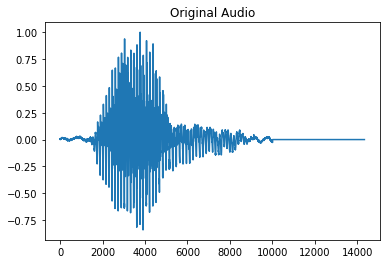

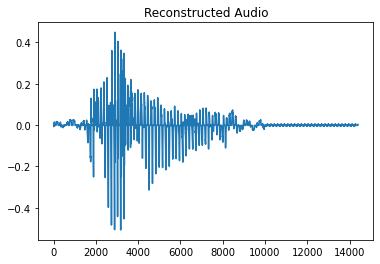

In [ ]:
import matplotlib.pyplot as plt
original_file = '/content/results/AudioMNIST/Autoencoder/1986/samples/1_17_40_original.wav'
reconstructed_file = '/content/results/AudioMNIST/Autoencoder/1986/samples/1_17_40.wav'

# Orignal Signal
sig, fs = torchaudio.load(original_file)
plt.title("Original Audio")
plt.plot(sig.squeeze())
plt.show()

# Reconstruction
rec, fs = torchaudio.load(reconstructed_file)
plt.title("Reconstructed Audio")
plt.plot(rec.squeeze())
plt.show()

Audio(rec, rate=fs)

You can compare the reconstructed audio with the original one:

In [ ]:
Audio(sig, rate=fs)

From the plots, you should see that the waveforms are pretty different. If you play the reconstructed signal, you should hear a lot of distortion due to compression. However, the content of the signal should stay ineligible. For instance, you should hear a "1" in this signal.

**Run the code below** to store the best encoder:

In [ ]:
!cp results/AudioMNIST/Autoencoder/1986/save/CKPT*/encoder.ckpt encoder_best.ckpt 

##**Exercise 3 - Classification**

Now, we will build a digit classifier on top of the learned features. This is very similar to what was done in the previous lab, but we replace the feature extraction and embedding block with the learned autoencoder:

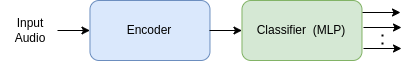

### **Exercise 3.1 - Encoder Fine-Tuning**

The encoder is a convolutional neural network. The main advantage over traditional feature extraction (e.g., FBANKs) is that we can backpropagate through it and fine-tune it during training. This approach is usually very effective as it adapts the learned features to the final task (called the downstream task).

In this exercise, we train the MLP digit classifier on top of the encoded representations. The encoder is fine-tuned while training the classifier.

**Run the code below** to store the hyperparameters of the digit classifier.

In [ ]:
%%file hparams_classifier_finetuned.yaml

# #################################
# Digit Classifier with a Pretrained autoencoder
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

output_folder: !ref ./results/AudioMNIST/Classifier-fine-tuned/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: train.json
valid_annotation: valid.json
test_annotation: test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch


# Training Parameters
number_of_epochs: 30
batch_size: 64
lr_start: 0.001
lr_final: 0.0001
n_classes: 10 # In this case, we have 10 digits
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Encoder 
n_fea: 40 
encoder: !new:models.Encoder

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <n_fea>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: 128
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    encoder: !ref <encoder>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <encoder>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>

# This object is used to pretrain the elements listed in loadables with
# the parameters stored in the corresponding paths.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
   collect_in: !ref <save_folder>
   loadables:
      encoder: !ref <encoder>
   paths:
      encoder: /content/encoder_best.ckpt

**Complete the code below** to train the digit classifier. You need to complete the forward and compute objective methods. You also need to resample the data on-the-fly to get 16 kHz data. You can draw inspiration from the previous lab (you need to remove the feature extraction and embedding computation and replace it with the encoder).

In [ ]:
%%file train.py

#!/usr/bin/env python3
"Recipe for training a digit classification system."
import os
import sys
import torch
import torchaudio
from speechbrain.utils.distributed import run_on_main
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.dataio.dataio import length_to_mask

# Brain class for speech enhancement training
class DigitBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """

        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)

        # Unpacking batch 
        wavs, lens = batch.sig

        # Compute encoded representations
        # Your code here. Aim for 1-2 line. 
        # Make sure you feed the encoder with the expected tensor shape. 
        # The encoded feature should have the format [batch,time, channels].

        # Average the encoder representation over time (to get a single
        # vector for the classifier)
        abs_len = (lens * enc_fea.shape[1]).int()
        mask = length_to_mask(abs_len)
        masked_x = enc_fea * mask.unsqueeze(2)
        embeddings = masked_x.sum(dim=1)/mask.sum(dim=1, keepdim=True)
        embeddings = embeddings.unsqueeze(1)
        
        # Final classification
        predictions = self.modules.classifier(embeddings)

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        
        _, lens = batch.sig
        labels, _ = batch.digit_encoded

        # Compute the cost function.
        # Your code here. Aim for 1 line
        loss = 

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, labels, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, labels, lens)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav)

        # Resampling
        # Your code here. Aim for 1-2 lines
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("digit")
    @sb.utils.data_pipeline.provides("digit", "digit_encoded")
    def label_pipeline(digit):
        """Defines the pipeline to process the digit labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield digit
        digit_encoded = label_encoder.encode_label_torch(digit)
        yield digit_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "digit_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="digit",
    )

    return datasets


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".
    datasets = dataio_prep(hparams)
    
    # Download and Pretrain the encoder
    hparams["pretrainer"].collect_files()
    hparams["pretrainer"].load_collected()
    hparams["encoder"].to(run_opts["device"])

    # Initialize the Brain object to prepare for mask training.
    digit_brain = DigitBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    digit_brain.fit(
        epoch_counter=digit_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = digit_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["dataloader_options"],
    )


**Run the code below** to start training.

In [ ]:
# To start from scratch, you need to remove the output folder.
# Otherwise, speechbrain starts from the last valid checkpoint.
#!rm -rf ./results/AudioMNIST/Classifier-fine-tuned/

!python train.py hparams_classifier_finetuned.yaml

You should obtain training logs similar to these:



```
Epoch: 1, lr: 1.00e-03 - train loss: 2.29 - valid loss: 2.22, valid error: 8.40e-01
Epoch: 2, lr: 9.69e-04 - train loss: 2.02 - valid loss: 2.03, valid error: 7.55e-01
Epoch: 3, lr: 9.38e-04 - train loss: 1.83 - valid loss: 1.92, valid error: 7.37e-01
Epoch: 4, lr: 9.07e-04 - train loss: 1.65 - valid loss: 1.64, valid error: 7.03e-01
Epoch: 5, lr: 8.76e-04 - train loss: 1.57 - valid loss: 2.48, valid error: 7.47e-01
Epoch: 6, lr: 8.45e-04 - train loss: 1.49 - valid loss: 5.86, valid error: 8.98e-01
Epoch: 7, lr: 8.14e-04 - train loss: 1.45 - valid loss: 1.37, valid error: 5.26e-01
Epoch: 8, lr: 7.83e-04 - train loss: 1.40 - valid loss: 4.47, valid error: 8.61e-01
Epoch: 9, lr: 7.52e-04 - train loss: 1.37 - valid loss: 2.26, valid error: 7.94e-01
Epoch: 10, lr: 7.21e-04 - train loss: 1.31 - valid loss: 1.48, valid error: 5.66e-01
Epoch: 11, lr: 6.90e-04 - train loss: 1.31 - valid loss: 2.88, valid error: 7.90e-01
Epoch: 12, lr: 6.59e-04 - train loss: 1.28 - valid loss: 2.72, valid error: 8.23e-01
Epoch: 13, lr: 6.28e-04 - train loss: 1.24 - valid loss: 1.79, valid error: 6.43e-01
Epoch: 14, lr: 5.97e-04 - train loss: 1.25 - valid loss: 2.16, valid error: 6.76e-01
Epoch: 15, lr: 5.66e-04 - train loss: 1.22 - valid loss: 1.45, valid error: 5.75e-01
Epoch: 16, lr: 5.34e-04 - train loss: 1.23 - valid loss: 2.10, valid error: 7.20e-01
Epoch: 17, lr: 5.03e-04 - train loss: 1.21 - valid loss: 2.87, valid error: 7.16e-01
Epoch: 18, lr: 4.72e-04 - train loss: 1.20 - valid loss: 1.40, valid error: 5.13e-01
Epoch: 19, lr: 4.41e-04 - train loss: 1.17 - valid loss: 1.88, valid error: 7.05e-01
Epoch: 20, lr: 4.10e-04 - train loss: 1.18 - valid loss: 1.53, valid error: 6.22e-01
Epoch: 21, lr: 3.79e-04 - train loss: 1.18 - valid loss: 2.42, valid error: 7.35e-01
Epoch: 22, lr: 3.48e-04 - train loss: 1.14 - valid loss: 3.11, valid error: 8.40e-01
Epoch: 23, lr: 3.17e-04 - train loss: 1.14 - valid loss: 2.04, valid error: 7.49e-01
Epoch: 24, lr: 2.86e-04 - train loss: 1.12 - valid loss: 1.24, valid error: 4.56e-01
Epoch: 25, lr: 2.55e-04 - train loss: 1.14 - valid loss: 1.22, valid error: 4.95e-01
Epoch: 26, lr: 2.24e-04 - train loss: 1.13 - valid loss: 2.06, valid error: 7.52e-01
Epoch: 27, lr: 1.93e-04 - train loss: 1.11 - valid loss: 1.44, valid error: 5.04e-01
Epoch: 28, lr: 1.62e-04 - train loss: 1.12 - valid loss: 2.27, valid error: 6.45e-01
Epoch: 29, lr: 1.31e-04 - train loss: 1.09 - valid loss: 1.34, valid error: 4.74e-01
Epoch: 30, lr: 1.00e-04 - train loss: 1.09 - valid loss: 1.12, valid error: 4.29e-01
Epoch loaded: 30 - test loss: 1.58, test error: 5.49e-01
```






### **Exercise 3.2 - Frozen Encoder**
Another alternative is to not fine-tune the encoder but keep it frozen during training.

**Write the train.py** to train the model with the frozen encoder. You can copy and paste the code from the previous exercise and do the needed modification. 
Essentially, you need to put the model in eval modality and avoid computing the gradient (using `torch.no_grad()`). This can be done in the forward method.

In [ ]:
%%file train.py

# Your code here


**Run the code below** to start training.

In [ ]:
# To start from scratch, you need to remove the output folder.
# Otherwise, speechbrain starts from the last valid checkpoint.
#!rm -rf ./results/AudioMNIST/Classifier-frozen/

!python train.py hparams_classifier_finetuned.yaml --output_folder=results/AudioMNIST/Classifier-frozen/

You should obtain something like this:



```
Epoch: 1, lr: 1.00e-03 - train loss: 2.29 - valid loss: 2.32, valid error: 8.86e-01
Epoch: 2, lr: 9.69e-04 - train loss: 2.19 - valid loss: 2.21, valid error: 7.85e-01
Epoch: 3, lr: 9.38e-04 - train loss: 2.14 - valid loss: 2.19, valid error: 7.74e-01
Epoch: 4, lr: 9.07e-04 - train loss: 2.08 - valid loss: 2.18, valid error: 7.77e-01
Epoch: 5, lr: 8.76e-04 - train loss: 2.04 - valid loss: 2.13, valid error: 7.78e-01
Epoch: 6, lr: 8.45e-04 - train loss: 2.01 - valid loss: 2.13, valid error: 7.84e-01
Epoch: 7, lr: 8.14e-04 - train loss: 1.99 - valid loss: 2.10, valid error: 7.67e-01
Epoch: 8, lr: 7.83e-04 - train loss: 1.97 - valid loss: 2.09, valid error: 7.83e-01
Epoch: 9, lr: 7.52e-04 - train loss: 1.95 - valid loss: 2.08, valid error: 7.57e-01
Epoch: 10, lr: 7.21e-04 - train loss: 1.93 - valid loss: 2.08, valid error: 7.46e-01
Epoch: 11, lr: 6.90e-04 - train loss: 1.93 - valid loss: 2.06, valid error: 7.46e-01
Epoch: 12, lr: 6.59e-04 - train loss: 1.91 - valid loss: 2.09, valid error: 7.79e-01
Epoch: 13, lr: 6.28e-04 - train loss: 1.92 - valid loss: 2.06, valid error: 7.57e-01
Epoch: 14, lr: 5.97e-04 - train loss: 1.89 - valid loss: 2.09, valid error: 7.58e-01
Epoch: 15, lr: 5.66e-04 - train loss: 1.89 - valid loss: 2.05, valid error: 7.62e-01
Epoch: 16, lr: 5.34e-04 - train loss: 1.87 - valid loss: 2.05, valid error: 7.75e-01
Epoch: 17, lr: 5.03e-04 - train loss: 1.85 - valid loss: 2.03, valid error: 7.34e-01
Epoch: 18, lr: 4.72e-04 - train loss: 1.86 - valid loss: 2.05, valid error: 7.67e-01
Epoch: 19, lr: 4.41e-04 - train loss: 1.85 - valid loss: 2.04, valid error: 7.80e-01
Epoch: 20, lr: 4.10e-04 - train loss: 1.85 - valid loss: 2.03, valid error: 7.42e-01
Epoch: 21, lr: 3.79e-04 - train loss: 1.83 - valid loss: 2.03, valid error: 7.60e-01
Epoch: 22, lr: 3.48e-04 - train loss: 1.82 - valid loss: 2.02, valid error: 7.57e-01
Epoch: 23, lr: 3.17e-04 - train loss: 1.82 - valid loss: 2.01, valid error: 7.48e-01
Epoch: 24, lr: 2.86e-04 - train loss: 1.81 - valid loss: 2.02, valid error: 7.41e-01
Epoch: 25, lr: 2.55e-04 - train loss: 1.81 - valid loss: 2.01, valid error: 7.57e-01
Epoch: 26, lr: 2.24e-04 - train loss: 1.81 - valid loss: 1.99, valid error: 7.45e-01
Epoch: 27, lr: 1.93e-04 - train loss: 1.79 - valid loss: 2.00, valid error: 7.48e-01
Epoch: 28, lr: 1.62e-04 - train loss: 1.80 - valid loss: 2.00, valid error: 7.52e-01
Epoch: 29, lr: 1.31e-04 - train loss: 1.79 - valid loss: 2.00, valid error: 7.63e-01
Epoch: 30, lr: 1.00e-04 - train loss: 1.79 - valid loss: 2.00, valid error: 7.60e-01
Epoch loaded: 17 - test loss: 2.13, test error: 7.56e-01


```



### **Conclusion**
We trained an autoencoder and injected the representation learned by the encoder into a digit classifier. We tested two different conditions:

1. Fine-tuning the encoder
2. Freezing the encoder

I obtained the following classification error rates:
- Pretrained encoder: 54.9%
- Frozen encoder: 75.6%


Variations (also pretty large) over these results are possible due to the small dataset used and different initialization points.

Freezing the encoder does not provide good results because the classifier has little capacity.

Note that the results obtained in this lab are much worse than those achieved in the last lab. In the previous lab, we were using hand-crafted features that are very effective. In this case, we learned the features from the raw audio directly using a small model trained on little data. This makes this task very challenging. 

This was just a very formative exercise and keep in mind that you can easily do better with a much larger dataset and a bigger model.


That's all!